# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from ml.visualization import plot_confusion_matrix, plot_learning_curve
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split


np.random.seed(0)  # Para mayor determinismo

## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [31]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")
display(dataset.head())

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [53]:
y_train.describe()

count    1483.000000
mean        0.171274
std         0.376876
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: TARGET, dtype: float64

In [54]:
X_train.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000,1483.000000
mean,18955.023601,76738.047202,107826.577883,8.710047,0.179366,0.333783,180.075608,1.124747,21.924477,34.564637
std,10673.976390,46617.582166,56921.281679,7.500037,0.667487,0.967689,84.265732,1.634216,9.430960,9.710183
min,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,8.055265,0.000000,0.000000,0.838118
25%,12000.000000,48778.000000,70658.500000,3.000000,0.000000,0.000000,117.048948,0.000000,16.000000,29.301550
50%,16800.000000,67272.000000,94394.000000,7.000000,0.000000,0.000000,174.474724,1.000000,21.000000,35.034481
75%,23700.000000,94711.500000,124404.000000,13.000000,0.000000,0.000000,231.227649,2.000000,27.000000,39.300230
max,89000.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


Se puede ver la gran variabilidad de rangos que hay en los datos para cada columna. Esta diferencia de rango puede influir en el entrenamiento del modelo al darle más importancia a variables con valores muy grandes, por lo que decidimos normalizar los datos aplicando a cada variable la siguiente transformación:


$$
X'_i = \frac{X_i - mean(X_i)}{std(X_i)}
$$

Esto lo vamos a realizar para los datos de entrenamiento, y luego para la predicción se va a utilizar la media y el desvío aprendidos de los datos de entrenamiento

In [55]:
# Función para normalizar futuros datos
def normalizar(X):
    mean = X_train.mean()
    std = X_train.std()
    return (X - mean) / std

normalizar(X_train).describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1.483000e+03,1.483000e+03,1.483000e+03,1.483000e+03,1.483000e+03,1.483000e+03,1.483000e+03,1.483000e+03,1.483000e+03,1.483000e+03
mean,-4.791252e-18,1.629026e-16,6.228628e-17,3.353877e-17,-3.593439e-17,1.916501e-17,-2.970577e-16,6.108847e-17,-1.443365e-16,4.443887e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616551e+00,-1.525413e+00,-1.522850e+00,-1.161334e+00,-2.687186e-01,-3.449278e-01,-2.041403e+00,-6.882487e-01,-2.324734e+00,-3.473315e+00
25%,-6.515869e-01,-5.997747e-01,-6.529733e-01,-7.613359e-01,-2.687186e-01,-3.449278e-01,-7.479513e-01,-6.882487e-01,-6.281945e-01,-5.420173e-01
50%,-2.018951e-01,-2.030574e-01,-2.359852e-01,-2.280052e-01,-2.687186e-01,-3.449278e-01,-6.646693e-02,-7.633454e-02,-9.802580e-02,4.838678e-02
75%,4.445369e-01,3.855509e-01,2.912342e-01,5.719909e-01,-2.687186e-01,-3.449278e-01,6.070325e-01,5.355796e-01,5.381767e-01,4.876935e-01
max,6.562220e+00,6.921722e+00,7.111987e+00,4.305306e+00,1.471285e+01,9.988970e+00,1.172669e+01,7.266635e+00,4.567459e+00,1.128963e+01


## Ejercicio 2: Elección de un modelo

Basándose en lo visto en el teórico escojan y justifiquen un modelo de aprendizaje automático. Recuerden que los pasos para elegir un modelo son:

### Selección de hipótesis

El espacio de hipótesis que vamos a plantear es el de la regresión logística:

$$
\mathcal{F} = \left\{ h_{w,w_o}(x) := \frac{1}{1 + e^{-w^T x + w_0 }} : w \in \mathbb{R}^n, w_0 \in \mathbb{R} \right\}
$$

Donde los parámetros a determinar va a ser el vector $ w $, con la misma cantidad de dimensiones que de variables en el dataset, y la constante $w_0$

### Selección de regularizador

Se usará de término de regularización la norma L2

### Selección de función de coste

La función de costo es la de la regresión logística con el término de regularización:

$$
J(w,w_0) = - \sum_{i=1}^n \left[ y^{(i)} \log (h_{w,w_o}(x^{(i)})) + (1-y^{(i)})\log (1-h_{w,w_o}(x^{(i)})) \right] + \lambda ||w||_2^2
$$

Donde el valor de $\lambda$ va a ser un hiper-parámetro del problema.

### Justificación de las selecciones

Se elije este modelo porque no solo busca la clasificación, sino que además la función de decisión devuelve un valor entre 0 y 1, lo que puede tratarse como la probabilidad de pertenecer a una clase o a la otra. 

Este problema, al tratarse de tomar una decisión sobre si otorgar o no un crédito, puede ser más interesante tener esa probabilidad de pertenecer a la clase, más que la predicción en sí. 

La elección de trabajar con un regularizador en la función de coste se debe a poder controlar los valores de los parámetros, no permitiendole al modelo encontrar valores de $w$ muy específicos que puedan estar provocando un *overfitting*.

## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

Para este problema vamos a tener 2 hiperparámetros para encontrar, por un lado la tasa de regularización (*alpha*) y por otro lado la tasa de entrenamiento (*eta0*) 

In [56]:
exploring_params = {
        'eta0': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],  # Tasa de entrenamiento
        'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]  # Tasa de regularización
    }
m = SGDClassifier(loss='log', tol=1e-3)
model = GridSearchCV(m, exploring_params, cv=5, scoring='roc_auc')
model.fit(normalizar(X_train), y_train)

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("ROC_AUC: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))

Mejor conjunto de parámetros:
{'alpha': 0.01, 'eta0': 0.001}

Puntajes de la grilla:

ROC_AUC: 0.793 (+/-0.000) para los parámetros {'alpha': 1, 'eta0': 1}
ROC_AUC: 0.793 (+/-0.000) para los parámetros {'alpha': 1, 'eta0': 0.1}
ROC_AUC: 0.793 (+/-0.000) para los parámetros {'alpha': 1, 'eta0': 0.01}
ROC_AUC: 0.792 (+/-0.000) para los parámetros {'alpha': 1, 'eta0': 0.001}
ROC_AUC: 0.793 (+/-0.000) para los parámetros {'alpha': 1, 'eta0': 0.0001}
ROC_AUC: 0.793 (+/-0.000) para los parámetros {'alpha': 1, 'eta0': 1e-05}
ROC_AUC: 0.793 (+/-0.000) para los parámetros {'alpha': 1, 'eta0': 1e-06}
ROC_AUC: 0.800 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 1}
ROC_AUC: 0.800 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1}
ROC_AUC: 0.799 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.01}
ROC_AUC: 0.799 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.001}
ROC_AUC: 0.799 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.0001}
ROC_AUC: 0.799 (+/-0.000) pa

## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

Reporte de clasificación para el mejor clasificador (sobre conjunto de test):

             precision    recall  f1-score   support

          0       0.89      0.99      0.94       316
          1       0.84      0.29      0.43        55

avg / total       0.88      0.89      0.86       371




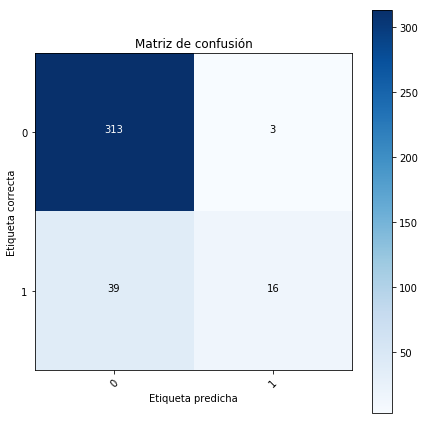

In [57]:
print("Reporte de clasificación para el mejor clasificador (sobre conjunto de test):", end="\n\n")
y_true, y_pred = y_test, model.predict(normalizar(X_test))
print(classification_report(y_true, y_pred), end="\n\n")

plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], title="Matriz de confusión")

Como conclusión del modelo entrenado podemos decir que tiene un buen comportamiento para predecir la clase del 0, con una precisión cercana al 90%, mientras que al tener un 99% de *recall* nos sugiere que es prácticamente imposible que el modelo prediga la clase del 1 cuando debía predecir el 0.

Este comportamiento es opuesto para la clase positiva. Si bien se tiene un buen indice de precisión, éste solo es así al tener las clases tan desbalanceadas en el dataset. Los otros índices no reflejan un buen comportamiento. 

En la matriz de confusión se puede ver el buen comportamiento para la clase del 0, pero la indecisión para la clase del 1. Además también se refleja el desbalanceo de clases

## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

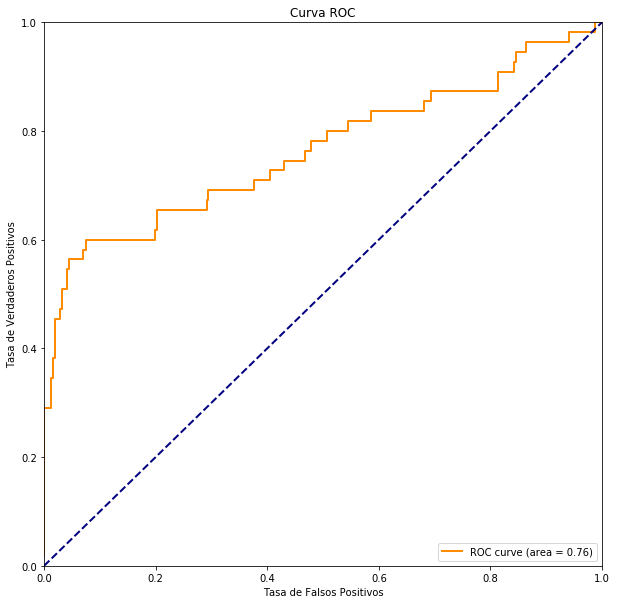

In [110]:
y_proba = model.predict_proba(normalizar(X_test))[:,1]
fpr, tpr, tresh = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

El modelo utilizó como unmbral de decisión el valor de 0.5, es decir que si el modelo decía que el registro tenía más de 0.5 de probabilidad de pertenecer a la clase positiva la asignaba a esa clase, y sino a la clase del 0.

Este umbral, si bien en sentido teórico parece ser el correcto, no tiene porque funcionar siempre. Por lo que con la curva ROC, vamos a darnos una idea de que otro umbral se podría utilizar para tener otros resultados.

En la curva ROC en el eje x graficamos la tasa de falsos positivos, y en el eje y la tasa de verdaderos positivos. Se puede ir viend ocmo avanza la curva a lo largo de que se cambie el umbral de decisión. El punto ideal sería encontrar un umbral que se acerque lo mayor posible al punto (0,1), en el que no tenemos falsos positivos.

Para seleccionar el nuevo umbral, vamos a calcular la distancia de la curva al punto (0,1), encontrar el mínimo y elegir el umbral correspondiente. 

In [111]:
dist = (fpr*fpr + (1 - tpr)*(1 - tpr))
indice_minimo = dist.argmin()
umbral = tresh[indice_minimo]

print('Umbral : %0.4f' % umbral)

Umbral : 0.1854


Con este nuevo umbral vamos a calcular y analizar las métricas, con respecto a las originales.

In [112]:
print("Métricas para la predicción orignal")
print(classification_report(y_true, y_pred), end="\n\n")

print("Métricas para la nueva predicción")
print(classification_report(y_true, (y_proba > 0.1854)), end="\n\n")


Métricas para la predicción orignal
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       316
          1       0.84      0.29      0.43        55

avg / total       0.88      0.89      0.86       371


Métricas para la nueva predicción
             precision    recall  f1-score   support

          0       0.93      0.79      0.86       316
          1       0.36      0.65      0.46        55

avg / total       0.84      0.77      0.80       371




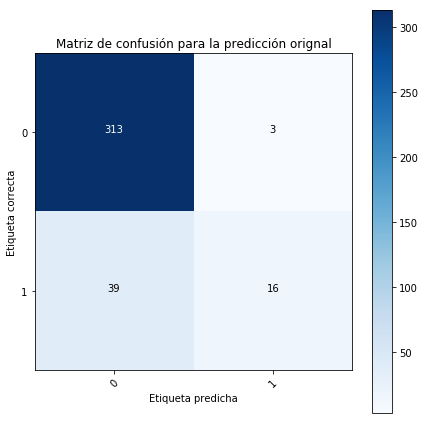

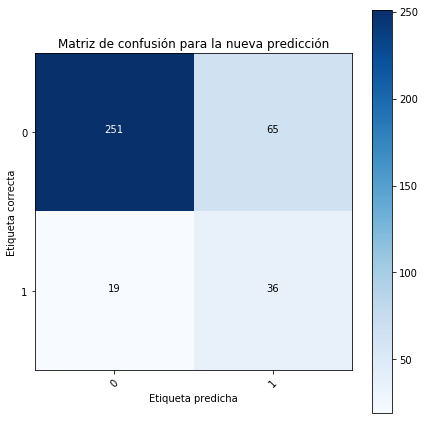

In [120]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=[0,1], title="Matriz de confusión para la predicción orignal")
plt.show()

plt.figure(figsize=(6,6))
plot_confusion_matrix(confusion_matrix(y_true, (y_proba > 0.1854)), classes=[0,1], title="Matriz de confusión para la nueva predicción")
plt.show()

Esta nueva clasificación parece haber buscado corregir el problema de predecir mayoritariamente la clase del 0, lo que llevó a un gran número de falsos positivos para la clase del 1. En las métricas se puede ver claramente que el problema del *recall* para la clase del 1 mejora, pero a costa de perder mucha precision.

Si bien los resultados del nuevo predictor parecen peores, se cambió el tipo de error, por lo que la decisión de que tipo de error es mejor debería ser tomada por la persona interesada en utilizar el modelo y que conozca el problema.